In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
tracks = pd.read_csv('/content/sample_data/fma-rock-vs-hiphop.csv')
music_features = pd.read_json('/content/sample_data/echonest-metrics.json',precise_float=True)

In [ ]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [ ]:
music_features.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


Merge these two datasets, only include relevant columns from both

In [ ]:
audio_data=music_features.merge(tracks[['genre_top', 'track_id']], on='track_id')
audio_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [ ]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


Feature Reduction
This is important as with many features, we run the risk of overfitting our model. At the same time, a reduced number of features will decrease the computation time of the model making it predict results much quicker.

First lets look at correlations and then try Principal Component Analysis (PCA).

1. Checking relationships between variables/features

This is done to check for variables that have strong correlations with each other, this will help to avoid feature redundancy.

In [ ]:
correlations = audio_data.corr()
correlations.style.background_gradient()

<ipython-input-7-90f3cb628d53>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = audio_data.corr()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


No pair of features have a strong enough correlation that we can eliminate a feature. Hence, lets now use the PCA approach.

To avoid bais that may be introduced by higher values of certain features, first normalize the data.

In [ ]:
features = audio_data.drop(['genre_top','track_id'],axis=1)
labels = audio_data['genre_top']

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
pca = PCA()
pca.fit(scaled_features)
exp_variance = pca.explained_variance_ratio_
num_components = pca.n_components_

I use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Text(0.5, 0, 'Principal Component #')

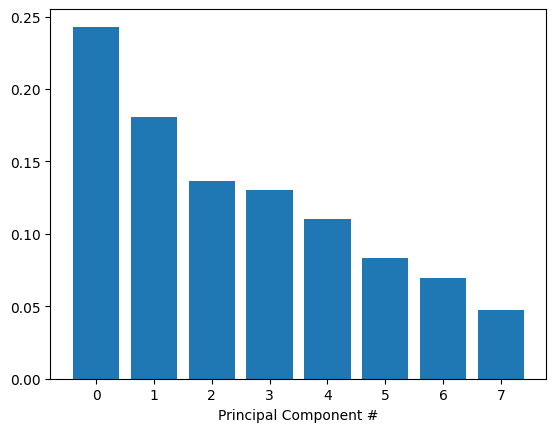

In [ ]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(num_components), exp_variance)
ax.set_xlabel('Principal Component #')

There does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

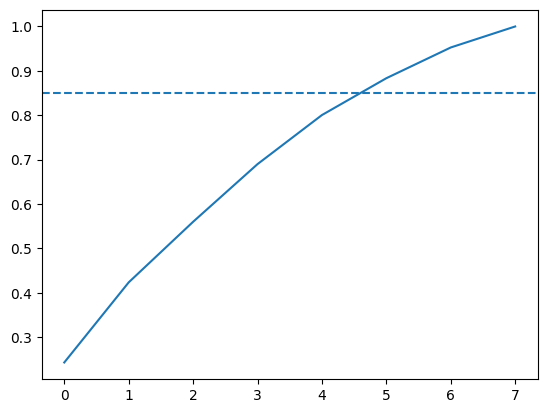

In [ ]:
cum_exp_variance = np.cumsum(exp_variance) #calculate the cumulative explained variance

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--') #for considering features needed to explain 85% of the variance

From the figure, I can say about 6 features are needed to explain 85% of the variance, hence this is the number of features I will use to carry out the model training with.

In [ ]:
n_components = 6

In [ ]:
#finally perform PCA with the chosen number of components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)

In [ ]:
pca_projection.shape

(4802, 6)

The shape confirms that we now have 6 features in total.

# **Model Training**

In [ ]:
#split data into test and train data
X_train, X_test, y_train, y_test = train_test_split(pca_projection,labels,random_state=10)

Train a Decision Tree Classifier Model

In [ ]:
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [ ]:
predictions_dt = model_dt.predict(X_test)
print("Decision Tree Classifier:", model_dt.score(X_test,y_test))

Decision Tree Classifier: 0.8434637801831807


Train a Logistic Regression Model

In [ ]:
model_lg = LogisticRegression(random_state=10)
model_lg.fit(X_train,y_train)

LogisticRegression(random_state=10)

In [ ]:
predictions_lg = model_lg.predict(X_test)
print("Logistic Regression:", model_lg.score(X_test,y_test))

Logistic Regression: 0.8784346378018318


In [ ]:
report_dt = classification_report(y_test,predictions_dt)
report_lg = classification_report(y_test,predictions_lg)

print("Decision Tree Classifier: \n", report_dt)
print("Logistic Regression: \n", report_lg)

Decision Tree Classifier: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Both the models- Decision Tree and Logitic Regressor perform almost the same with about 84-87% accuracy. But, one important thing you can notice in the classification reports is that both these models predict Rock songs pretty well with an accuracy of 90%. However the prediction rate for Hip-Hop is much lower. In an ideal world this is not how our classifier should be like. I will aim to get both the accuracies to the same level, which then would mean our classifier is doing a good job.

Viewing the data- there is a class imbalance data. More Rock songs present in our dataset than Hip-Hop

<Axes: xlabel='genre_top', ylabel='Count'>

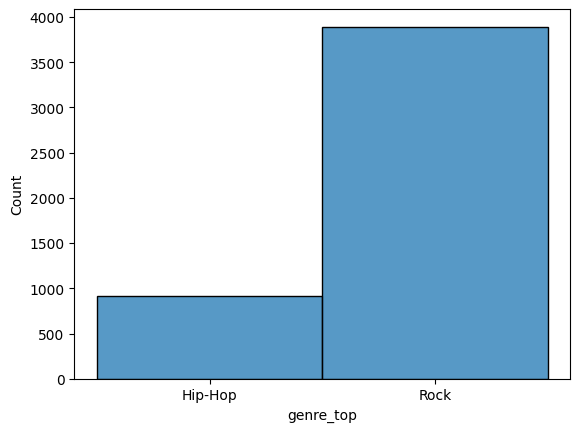

In [ ]:
sns.histplot(audio_data['genre_top'])

In [ ]:
# Subset only the hip-hop tracks, and then only the rock tracks
hip_hop = audio_data.loc[audio_data['genre_top'] == 'Hip-Hop']
rock = audio_data.loc[audio_data['genre_top'] == 'Rock']

In [ ]:
hip_hop.shape

(910, 10)

In [ ]:
rock.shape

(3892, 10)

3892 rock songs compared to only 910 hip hop songs. Remove this imbalance by sampling the rock songs to have the same number as hip hop

In [ ]:
rock = rock.sample(hip_hop.shape[0], random_state=10)

In [ ]:
#concatenate to create the balanced dataset
balanced_data = pd.concat([rock, hip_hop])

In [ ]:
balanced_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
773,4038,0.825838,0.263645,0.797948,0.842318,0.177089,0.045277,166.580,0.713586,Rock
2273,19501,0.966635,0.386114,0.651980,0.869472,0.353138,0.032208,130.767,0.712374,Rock
2846,31252,0.721510,0.358035,0.948187,0.801184,0.105706,0.095522,125.884,0.208728,Rock
2147,17947,0.617370,0.487321,0.918848,0.817050,0.089908,0.040337,129.565,0.268893,Rock
2654,27421,0.025464,0.245523,0.422381,0.938011,0.441009,0.038795,149.960,0.439876,Rock


In [ ]:
#features and labels for the new balanced data
features = balanced_data.drop(['genre_top', 'track_id'], axis=1)
labels = balanced_data['genre_top']

In [ ]:
pca_projection = pca.fit_transform(scaler.fit_transform(features))
pca_projection.shape

(1820, 6)

In [ ]:
#split this balanced data into test and train
X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=10)

In [ ]:
#train decision tree on the balanced data
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(X_train,y_train)
predictions_dt = model_dt.predict(X_test)

In [ ]:
#train logistic regression on the balanced data
model_lr = LogisticRegression(random_state=10)
model_lr.fit(X_train,y_train)
predictions_lr = model_lr.predict(X_test)

In [ ]:
# compare the models
print("Decision Tree: \n", classification_report(y_test, predictions_dt))
print("Logistic Regression: \n", classification_report(y_test, predictions_lr))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



As you can now see, the classification rates for both rock and hip-hop are now almost the same. This mean that balancing our data has removed bias towards the more prevalent class.
To find the final actual performance accuracy of our models, I will use the K-Fold Cross Validation procedure. This step allows us to compare models in a more rigorous fashion.

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores = cross_val_score(model_dt, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Decision Tree Classifier Accuracy:", np.mean((scores)))

Decision Tree Classifier Accuracy: 0.7979227053140097


In [ ]:
scores = cross_val_score(model_lg, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Logistic Regression Accuracy:", np.mean((scores)))

Logistic Regression Accuracy: 0.8157971014492755


Successully able to classify songs as Rock or Hip-Hop using the audio data features with an accuracy of 81.5% using Logistic Regressor.